

---
<h1><big><center>MVA DLMI : Deep Learning for Medical Imaging 2019/2020</center></big></h1>

<h3><big><center> Khaoula Belahsen, Nadir El Manouzi </center></big></h3>


<h2><big><center> Ultrasound Nerve Segmentation</center></big></h2>
<h2><big><center> Final project code </center></big></h2>

</br>
<p align="center">
<img height=300px src="https://storage.googleapis.com/kaggle-competitions/kaggle/5144/logos/front_page.png"/></p>
<p align="center"></p>


# 1. Data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My Drive/DLMI/data/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/DLMI/data


## 1.2 Setting the directory 

In [0]:
# standard-module imports
import os

# Input data files are available in the "../input/" directory.

_dir = os.path.abspath('')
os.chdir(_dir)
print(_dir)
print(os.listdir(_dir))

/content/drive/My Drive/DLMI/data
['np_data', 'sample_submission.csv', 'train_masks.csv', 'Untitled Folder', '.ipynb_checkpoints', 'train', 'test_ids.npy', 'np_data (1)', 'test', 'res']


In [0]:
# standard-module imports
import os

# Input data files are available in the "../input/" directory.

_dir = os.path.abspath('')
os.chdir(_dir)
print(_dir)

# data
data_path = _dir
preprocess_path = os.path.join(_dir, 'np_data')

if not os.path.exists(preprocess_path):
    os.mkdir(preprocess_path)
print(os.listdir(_dir))

# train data
img_train_path = os.path.join(preprocess_path, 'imgs_train.npy')
img_train_mask_path = os.path.join(preprocess_path, 'imgs_mask_train.npy')
augmented_img_train_path = os.path.join(preprocess_path, 'augmented_imgs_train.npy')
augmented_img_train_mask_path = os.path.join(preprocess_path, 'augmented_imgs_mask_train.npy')
img_train_patients = os.path.join(preprocess_path, 'imgs_patient.npy')

# test data
img_test_path = os.path.join(preprocess_path, 'imgs_test.npy')
img_test_id_path = os.path.join(preprocess_path, 'imgs_id_test.npy')

print(os.listdir(preprocess_path))

/content/drive/My Drive/DLMI/data
['np_data', 'sample_submission.csv', 'train_masks.csv', 'Untitled Folder', '.ipynb_checkpoints', 'train', 'test_ids.npy', 'np_data (1)', 'test', 'res']
['imgs_patient.npy', 'imgs_train.npy', 'imgs_mask_train.npy', 'imgs_test.npy', 'imgs_id_test.npy', 'augmented_imgs_train.npy', 'augmented_imgs_mask_train.npy']


## 1.2 Load and create the data for train and test 

In [0]:
# ====================================================================================================================
# Data
# ====================================================================================================================

# standard-module imports
import os
import numpy as np
import cv2

image_rows = 420
image_cols = 580


def load_test_data():
    """Load test data from a .npy file.

    :return: np.array with test data.
    """
    print('Loading test data from %s' % img_test_path)
    imgs_test = np.load(img_test_path)
    return imgs_test


def load_test_ids():
    """Load test ids from a .npy file.

    :return: np.array with test ids. Shape (samples, ).
    """
    print('Loading test ids from %s' % img_test_id_path)
    imgs_id = np.load(img_test_id_path)
    return imgs_id


def load_train_data():
    """Load train data from a .npy file.

    :return: np.array with train data.
    """
    print('Loading train data from %s and %s' % (img_train_path, img_train_mask_path))
    imgs_train = np.load(img_train_path)
    imgs_mask_train = np.load(img_train_mask_path)
    return imgs_train, imgs_mask_train

def load_augmented_train_data():
    """Load train data from a .npy file.

    :return: np.array with train data.
    """
    print('Loading train data from %s and %s' % (augmented_img_train_path, augmented_img_train_mask_path))
    imgs_train = np.load(augmented_img_train_path)
    imgs_mask_train = np.load(augmented_img_train_mask_path)
    return imgs_train, imgs_mask_train


def load_patient_num():
    """Load the array with patient numbers from a .npy file

    :return: np.array with patient numbers
    """
    print('Loading patient numbers from %s' % img_train_patients)
    return np.load(img_train_patients)


def get_patient_nums(string):
    """Create a tuple (patient, photo) from image-file name patient_photo.tif

    :param string: image-file name in string format: patient_photo.tif
    :return: a tuple (patient, photo)

    >>> get_patient_nums('32_50.tif')
    (32, 50)
    """
    patient, photo = string.split('_')
    photo = photo.split('.')[0]
    return int(patient), int(photo)


def create_train_data():
    """
    Create an np.array with patient numbers and save it into a .npy file.
    Create an np.array with train images and save it into a .npy file.
    Create an np.array with train masks and save it into a .npy file.

    The np.array with patient numbers will have shape (samples, ).
        So for each train image saved, the patient number will be recorded exactly in the same order the images were saved.
    The np.array with train images will have shape (samples, rows, cols, channels).
    The np.array with train masks will have shape (samples, rows, cols, channels).
        The masks are saved in the same order as the images.
    """
    train_data_path = os.path.join(data_path, 'train')
    images = os.listdir(train_data_path)
    total = len(images) // 2

    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)
    imgs_mask = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)
    i = 0
    print('Creating training images...')
    img_patients = np.ndarray((total,), dtype=np.uint8)
    for image_name in images:

        # With "continue" skip the mask image in the iteration because the mask will be saved together with the image,
        # when we get the image in one of the next iterations. This guarantees that the images, masks and corresponding
        # patient numbers are all saved in the correct order.
        if 'mask' in image_name:
            continue

        # we got to this point, meaning that image_name is a name of a training image and not a mask.

        # recreate the mask's name fot this image
        # noinspection PyTypeChecker
        image_mask_name = image_name.split('.')[0] + '_mask.tif'
        # get the patient number of the image
        patient_num = image_name.split('_')[0]
        # read the image itself to an np.array
        img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
        # read the corresponding mask to an np.array
        img_mask = cv2.imread(os.path.join(train_data_path, image_mask_name), cv2.IMREAD_GRAYSCALE)

        imgs[i, :, :, 0] = img
        imgs_mask[i, :, :, 0] = img_mask
        img_patients[i] = patient_num
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    # saving patient numbers
    np.save(img_train_patients, img_patients)
    # saving train images
    np.save(img_train_path, imgs)
    # saving train masks
    np.save(img_train_mask_path, imgs_mask)
    print('Saving to .npy files done.')


def create_test_data():
    """
    Create an np.array with test data and save it into a .npy file.
    Create an np.array with ids for all images and save it into a .npy file.

    The np.array with test data will have shape (samples, rows, cols, channels).
    The np.array with test data ids will have shape (samples,). Each image id will be a number corresponding to the
    number in a test image name. For example image '8.tif' will have 8 as its image id.
    """
    test_data_path = os.path.join(data_path, 'test')
    images = os.listdir(test_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)
    imgs_id = np.ndarray((total,), dtype=np.int32)

    i = 0
    print('Creating test images...')
    for image_name in images:
        split = image_name.split('.')[0]
        if split.endswith(" (1)"):
          img_id = split[:-(len(" (1)"))]
          img_id = int(img_id)
        else : 
          img_id = int(image_name.split('.')[0])

        img = cv2.imread(os.path.join(test_data_path, image_name), cv2.IMREAD_GRAYSCALE)

        imgs[i, :, :, 0] = img
        imgs_id[i] = img_id

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save(img_test_path, imgs)
    np.save(img_test_id_path, imgs_id)
    print('Saving to .npy files done.')


# --------------------------------------------------------------------------------------------------------------------

# if __name__ == '__main__':
#     create_train_data()
#     create_test_data()

## 1.3  Data Augmentation

In [0]:
# ====================================================================================================================
# Data Augmentation
# ====================================================================================================================
import numpy as np
import os, random, h5py
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import rotate
from skimage.exposure import equalize_adapthist
from sklearn.model_selection import train_test_split


def random_rotate(X,y,intensity):
    Xf = np.array(X)
    yf = np.array(y)
    for i in range(X.shape[0]):
        delta = 30. * intensity # scale using augmentation intensity
        ran_delta = random.uniform(-delta, delta)
        
        Xf[i] = rotate(X[i], ran_delta, mode = 'constant', preserve_range=True)
        yf[i] = rotate(y[i], ran_delta, mode = 'constant', preserve_range=True)
    return Xf,yf

def vertical_flip(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    for i in range(X.shape[0]):
        Xf[i] = rotate(X[i], 180, mode='edge', preserve_range=True)
        yf[i] = rotate(y[i], 180, mode='edge', preserve_range=True)
    return Xf,yf
    
def random_flip(X,y):
    ud_indices = random.sample(range(X.shape[0]), int(X.shape[0]/2))
    lr_indices = random.sample(range(X.shape[0]), int(X.shape[0]/2))
    Xf = np.array(X)
    yf = np.array(y)
    
    Xf[ud_indices] = np.flipud(X[ud_indices])
    yf[ud_indices] = np.flipud(y[ud_indices])
    Xf[lr_indices] = np.fliplr(Xf[lr_indices])
    yf[lr_indices] = np.fliplr(yf[lr_indices])
    
    return Xf,yf    

def random_rotate90(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    for i in range(X.shape[0]):
        rand_deg = np.random.randint(0,4) * 90 #0, 90, 180, 270 deg
        
        Xf[i] = rotate(X[i], rand_deg, mode='constant', preserve_range=True)
        yf[i] = rotate(y[i], rand_deg, mode='constant', preserve_range=True)
    return Xf,yf        

def random_horizontal_flip(X,y):
    flip_indices = random.sample(range(X.shape[0]), int(X.shape[0]/2))
    Xf = np.array(X)
    yf = np.array(y)
    
    Xf[flip_indices] = X[flip_indices, :, ::-1]
    yf[flip_indices] = y[flip_indices, :, ::-1]
    
    return Xf,yf

def vertical_flip_cv2(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    (h,w) = Xf.shape[1:]
    center = (w/2, h/2)
    for i in range(X.shape[0]):
        M = cv2.getRotationMatrix2D(center, 180, 1.0)
        
        Xf[i] = cv2.warpAffine(X[i], M, (w,h), flags=cv2.INTER_LINEAR)
        yf[i] = cv2.warpAffine(y[i], M, (w,h), flags=cv2.INTER_LINEAR)
    return Xf,yf

In [0]:
# #test code
# X_test, y_test = trainImages[0:5,:], trainMasks[0:5,:]
# testX, testy = random_rotate(X_test, y_test,0.3)
# testX, testy = random_flip(testX, testy)
# testX, testy = random_rotate90(testX, testy)

# plt.figure(300)
# plt.subplot(221)
# plt.imshow(X_test[3,:,:],cmap='gray')

# plt.subplot(222)
# plt.imshow(y_test[3,:,:],cmap='gray')

# testX, testy = random_rotate(X_test, y_test,0.3)
# plt.subplot(223)
# plt.imshow(testX[3,:,:],cmap='gray')

# plt.subplot(224)
# plt.imshow(testy[3,:,:,1],cmap='gray')

# testX, testy = random_flip(testX, testy)

# plt.subplot(225)
# plt.imshow(testX[3,:,:,1],cmap='gray')

# plt.subplot(226)
# plt.imshow(testy[3,:,:,1],cmap='gray')

# testX, testy = vertical_flip(testX, testy)

# plt.subplot(227)
# plt.imshow(testX[3,:,:,1],cmap='gray')

# plt.subplot(228)
# plt.imshow(testy[3,:,:,1],cmap='gray')

In [0]:
# #test code
# test_idx = random.randint(0,4)
# plt.figure(200)
# plt.subplot(221)
# plt.imshow(X_test[test_idx,:,:],cmap='gray')

# plt.subplot(222)
# plt.imshow(y_test[test_idx,:,:],cmap='gray')

# plt.subplot(223)
# plt.imshow(testX[test_idx,:,:],cmap='gray')

# plt.subplot(224)
# plt.imshow(testy[test_idx,:,:],cmap='gray')

In [0]:
def create_augmented_train_data():
    """
    
    """
    imgs_train, imgs_mask_train = load_train_data()
    # augmented_img_train, augmented_img_train_mask = random_rotate90(imgs_train, imgs_mask_train)
    augmented_img_train, augmented_img_train_mask = random_flip(imgs_train, imgs_mask_train)
    augmented_img_train, augmented_img_train_mask = vertical_flip(augmented_img_train, augmented_img_train_mask)
    
    augmented_img_train = np.concatenate((imgs_train, augmented_img_train), axis=0)
    augmented_img_train_mask = np.concatenate((imgs_mask_train, augmented_img_train_mask), axis=0)

    # saving train images
    np.save(augmented_img_train_path, augmented_img_train)
    # saving train masks
    np.save(augmented_img_train_mask_path, augmented_img_train_mask)
    print('Saving to .npy files done.')

    print('Loading done.')



# 2. Evaluation Metrics 

In [0]:
# ====================================================================================================================
# metrics
# ====================================================================================================================

# standard-module imports
import numpy as np
from tensorflow.keras import backend as K  # tensorflow backend

smooth = 1.


def dice_coef(mask_1, mask_2, smooth=1):
    """Compute the dice coefficient between two equal-sized masks.

    Dice Coefficient: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    We need to add smooth, because otherwise 2 empty (all zeros) masks will throw an error instead of giving 1 as an output.

    :param mask_1: first mask
    :param mask_2: second mask
    :param smooth: Smoothing parameter for dice coefficient
    :return: Smoothened dice coefficient between two equal-sized masks
    """
    mask_1_flat = K.flatten(mask_1)
    mask_2_flat = K.flatten(mask_2)

    # for pixel values in {0, 1} multiplication is the intersection of masks
    intersection = K.sum(mask_1_flat * mask_2_flat)
    return (2. * intersection + smooth) / (K.sum(mask_1_flat) + K.sum(mask_2_flat) + smooth)



def dice_coef_loss(mask_pred, mask_true):
    """Calculate dice coefficient loss, when comparing predicted mask for an image with the true mask

    :param mask_pred: predicted mask
    :param mask_true: true mask
    :return: dice coefficient loss
    """
    return -dice_coef(mask_pred, mask_true)


def np_dice_coef(mask_1, mask_2, smooth=1):
    """Compute the dice coefficient between two equal-sized masks.
    
    Used for testing on artificially generated np.arrays

    Dice Coefficient: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    We need to add smooth, because otherwise 2 empty (all zeros) masks will throw an error instead of giving 1 as an output.

    :param mask_1: first mask
    :param mask_2: second mask
    :param smooth: Smoothing parameter for dice coefficient
    :return: Smoothened dice coefficient between two equal-sized masks
    """
    tr = mask_1.flatten()
    pr = mask_2.flatten()
    return (2. * np.sum(tr * pr) + smooth) / (np.sum(tr) + np.sum(pr) + smooth)


# --------------------------------------------------------------------------------------------------------------------

if __name__ == '__main__':
    a = np.random.random((420, 100))
    b = np.random.random((420, 100))
    res = np_dice_coef(a, b)
    print(res)


0.5012933380156163


# 3. Models 


## 3.1 Unet, ResUnet and Unet two heads 

In [0]:
# ====================================================================================================================
# u_model - needed for train
# ====================================================================================================================

# standard-module imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dense, Conv2DTranspose, Activation 
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from tensorflow.keras.layers import ELU, LeakyReLU 
from tensorflow.keras.layers import concatenate 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

# # separate-module imports
# from metric import dice_coef, dice_coef_loss


K.set_image_data_format('channels_last')  # (number of images, rows per image, cols per image, channels)


def inception_block(inputs, filters, split=False, activation='relu'):
    """Create an inception block with 2 options described in:
    https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

    Default option: split=FALSE
        Create an inception block described in v1, section b

    Alternative option: split=TRUE
        Create an inception block described in v2

    :param inputs: Input 4D tensor (samples, rows, cols, channels)
    :param filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    :param split: option of inception block
    :param activation: activation function to use everywhere in the block
    :return: output of the inception block, given inputs
    """
    assert filters % 16 == 0
    actv = activation == 'relu' and (lambda: LeakyReLU(0.0)) or activation == 'elu' and (lambda: ELU(1.0)) or None

    #
    # vertical 1
    #
    c1_1 = Conv2D(filters=filters // 4, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(inputs)

 
    #
    # vertical 2
    #
    c2_1 = Conv2D(filters=filters // 8 * 3, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(inputs)
    # no batch norm
    c2_1 = actv()(c2_1)
    if split:
        c2_2 = Conv2D(filters=filters // 2, kernel_size=(1, 3), kernel_initializer='he_normal', padding='same')(c2_1)
        c2_2 = BatchNormalization(axis=3)(c2_2)
        c2_2 = actv()(c2_2)
        c2_3 = Conv2D(filters=filters // 2, kernel_size=(3, 1), kernel_initializer='he_normal', padding='same')(c2_2)
    else:
        c2_3 = Conv2D(filters=filters // 2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(c2_1)

    #
    # vertical 3
    #
    c3_1 = Conv2D(filters=filters // 16, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(inputs)
    # no batch norm
    c3_1 = actv()(c3_1)
    if split:
        c3_2 = Conv2D(filters=filters // 8, kernel_size=(1, 5), kernel_initializer='he_normal', padding='same')(c3_1)
        c3_2 = BatchNormalization(axis=3)(c3_2)  # mode=batch_mode # 0 in this case
        c3_2 = actv()(c3_2)
        c3_3 = Conv2D(filters=filters // 8, kernel_size=(5, 1), kernel_initializer='he_normal', padding='same')(c3_2)
    else:
        c3_3 = Conv2D(filters=filters // 8, kernel_size=(5, 5), kernel_initializer='he_normal', padding='same')(c3_1)

    #
    # vertical 4
    #
    p4_1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    c4_2 = Conv2D(filters=filters // 8, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(p4_1)

    #
    # concatenating verticals together
    #
    res = concatenate([c1_1, c2_3, c3_3, c4_2], axis=3)
    res = BatchNormalization(axis=3)(res)
    res = actv()(res)
    return res


# needed for rblock (residual block)
def _shortcut(_input, residual):
    stride_width = _input.shape[1] // residual.shape[1]
    stride_height = _input.shape[2] // residual.shape[2]
    equal_channels = residual.shape[3] == _input.shape[3]

    shortcut = _input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual.shape[3], kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          kernel_initializer="he_normal", padding="valid")(_input)

    return add([shortcut, residual])


def rblock(inputs, kernel_size, filters, scale=0.1):
    """Create a scaled Residual block connecting the down-path and the up-path of the u-net architecture

    Activations are scaled by a constant to prevent the network from dying. Usually is set between 0.1 and 0.3. See:
    https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

    :param inputs: Input 4D tensor (samples, rows, cols, channels)
    :param filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    :param kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution
                        window. Can be a single integer to specify the same value for all spatial dimensions.
    :param scale: scaling factor preventing the network from dying out
    :return: output of a residual block
    """
    residual = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(inputs)
    residual = BatchNormalization(axis=3)(residual)
    residual = Lambda(lambda x: x * scale)(residual)
    res = _shortcut(inputs, residual)
    return ELU()(res)


def NConv2D(filters, kernel_size, padding='same', strides=(1, 1)):
    """Create a (Normalized Conv2D followed by ELU activation) function
    Conv2D -> BatchNormalization -> ELU()

    :param filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the
    convolution)
    :param kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution
                        window. Can be a single integer to specify the same value for all spatial dimensions.
    :param padding: one of "valid" or "same" (case-insensitive)
    :param strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height
                    and width. Can be a single integer to specify the same value for all spatial dimensions.
                    Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    :return: 2D Convolution function, followed by BatchNormalization across filters and ELU activation
    """

    def f(_input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding=padding)(_input)
        norm = BatchNormalization(axis=3)(conv)
        return ELU()(norm)

    return f



# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],
                  padding='same'):

    input_n_filters = input_layer.get_shape().as_list()[3]

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding)(
            input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):

        for i in range(2):
            if i == 0:

                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding)(
                    layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding)(
                add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    out_layer = add([layer, skip_layer])
    return out_layer


def up_and_concate(down_layer, layer):

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2))(down_layer)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])

    return concate




###############################################
###############################################
############### MODELS ####################
###############################################
###############################################

# U-net

def get_unet_classic(optimizer):
    """
    Creating and compiling the U-net

    :param optimizer: specifies the optimiser for the u-net, e.g. Adam, RMSProp, etc.
    :return: compiled u-net, Keras.Model object

    Function taken in : https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
    """

    # act = 'relu'

    #
    # down the U-net
    #
    IMG_ROWS, IMG_COLS = 96, 96 # 80, 112

    inputs = Input((IMG_ROWS, IMG_COLS, 1), name='main_input')

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #
    # bottom level of the U-net
    #

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5) 

    #
    # up the U-net
    #

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)

    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)    

    # output
    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid', name='main_output')(conv9)

    # creating a model
    model = Model(inputs=[inputs], outputs=[conv10])

    # compiling the model
    model.compile(optimizer=optimizer,
                  loss={'main_output': dice_coef_loss},
                  metrics=[dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)])

    return model


#########################################################################################################

# U-net inception with two outputs (One auxiliary head for predicting the probability of nerve presence)

def get_unet_inception_2head(optimizer):
    """
    Creating and compiling the U-net

    :param optimizer: specifies the optimiser for the u-net, e.g. Adam, RMSProp, etc.
    :return: compiled u-net, Keras.Model object
    """

    split = True
    act = 'elu'

    #
    # down the U-net
    #
    IMG_ROWS, IMG_COLS = 80, 112 


    inputs = Input((IMG_ROWS, IMG_COLS, 1), name='main_input')

    conv1 = inception_block(inputs, 32, split=split, activation=act)
    pool1 = NConv2D(32, kernel_size=(3, 3), strides=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)


    conv2 = inception_block(pool1, 64, split=split, activation=act)
    pool2 = NConv2D(64, kernel_size=(3, 3), strides=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = inception_block(pool2, 128, split=split, activation=act)
    pool3 = NConv2D(128, kernel_size=(3, 3), strides=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = inception_block(pool3, 256, split=split, activation=act)
    pool4 = NConv2D(256, kernel_size=(3, 3), strides=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    #
    # bottom level of the U-net
    #

    conv5 = inception_block(pool4, 512, split=split, activation=act)
    conv5 = Dropout(0.5)(conv5)

    #
    # auxiliary head for predicting probability of nerve presence
    #

    pre = Conv2D(1, kernel_size=(1, 1), kernel_initializer='he_normal', activation='sigmoid')(conv5)
    pre = Flatten()(pre)
    aux_out = Dense(1, activation='sigmoid', name='aux_output')(pre)

    #
    # up the U-net
    #

    after_conv4 = rblock(conv4, 1, 256)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), after_conv4], axis=3)
    conv6 = inception_block(up6, 256, split=split, activation=act)
    conv6 = Dropout(0.5)(conv6)

    after_conv3 = rblock(conv3, 1, 128)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), after_conv3], axis=3)
    conv7 = inception_block(up7, 128, split=split, activation=act)
    conv7 = Dropout(0.5)(conv7)


    after_conv2 = rblock(conv2, 1, 64)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), after_conv2], axis=3)
    conv8 = inception_block(up8, 64, split=split, activation=act)
    conv8 = Dropout(0.5)(conv8)

    after_conv1 = rblock(conv1, 1, 32)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), after_conv1], axis=3)
    conv9 = inception_block(up9, 32, split=split, activation=act)
    conv9 = Dropout(0.5)(conv9)

    # output
    conv10 = Conv2D(1, kernel_size=(1, 1), kernel_initializer='he_normal', activation='sigmoid', name='main_output')(
        conv9)

    # creating a model
    model = Model(inputs=inputs, outputs=[conv10, aux_out])

    # compiling the model
    model.compile(optimizer=optimizer,
                  loss={'main_output': dice_coef_loss, 'aux_output': 'binary_crossentropy'},
                  metrics={'main_output': [dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)], 'aux_output': 'acc'},
                  loss_weights={'main_output': 1., 'aux_output': 0.5})

    return model




########################################################################################################

# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
# adapted from https://github.com/lixiaolei1982/Keras-Implementation-of-U-Net-R2U-Net-Attention-U-Net-Attention-R2U-Net.-/blob/master/network.py

def r2_unet(optimizer):

  IMG_ROWS, IMG_COLS = 96, 96 
  
  inputs = Input((IMG_ROWS, IMG_COLS, 1), name='main_input')
  x = inputs
  depth = 4
  features = 16 # 64, 32 and 16 tested
  skips = []
  for i in range(depth):
    x = rec_res_block(x, features, batch_normalization=False)
    skips.append(x)
    x = MaxPooling2D((2,2))(x)

    features = features * 2

  x = rec_res_block(x, features, batch_normalization=False)

  for i in reversed(range(depth)):
    features = features // 2
    x = up_and_concate(x, skips[i])
    x = rec_res_block(x, features, batch_normalization=False)

  conv6 = Conv2D(1, (1,1), padding='same')(x)
  conv7 = Activation('sigmoid')(conv6)

  # creating a model
  model = Model(inputs=[inputs], outputs=[conv7])

  # compiling the model
  model.compile(optimizer=optimizer,
                loss= [dice_coef_loss],
                # loss = 'binary_crossentropy',
                metrics=[dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)]) 

  return model



# --------------------------------------------------------------------------------------------------------------------


# get_unet = get_unet_classic
# IMG_ROWS, IMG_COLS = 96, 96 # 80, 112 for the modified U-net (get_unet_inception_2head)


get_unet = get_unet_inception_2head
IMG_ROWS, IMG_COLS = 80, 112 


# get_unet = r2_unet
# IMG_ROWS, IMG_COLS = 96, 96 

# --------------------------------------------------------------------------------------------------------------------
if __name__ == '__main__':

    img_rows = IMG_ROWS
    img_cols = IMG_COLS

    # to check that model works without training, any kind of optimiser can be used
    model = get_unet(Adam(lr=1e-5))

    x = np.random.random((1, img_rows, img_cols, 1))
    res = model.predict(x, 1)
    print(res)
    print('params', model.count_params())
    print('layer num', len(model.layers))


inputs: (None, 96, 96, 1)
conv1 (None, 96, 96, 32)
pool1 (None, 48, 48, 32)
conv2 (None, 48, 48, 64)
pool2 (None, 24, 24, 64)
conv3 (None, 24, 24, 128)
pool3 (None, 12, 12, 128)
conv4 (None, 12, 12, 256)
pool4 (None, 6, 6, 256)
conv5 (None, 6, 6, 512)
up6 (None, 12, 12, 512)
conv6 (None, 12, 12, 256)
up7 (None, 24, 24, 256)
conv7 (None, 24, 24, 128)
up8 (None, 48, 48, 128)
conv8 (None, 48, 48, 64)
up9 (None, 96, 96, 64)
conv9 (None, 96, 96, 32)
conv10 (None, 96, 96, 1)
[[[[0.49845898]
   [0.49348718]
   [0.49880686]
   ...
   [0.49630877]
   [0.5005759 ]
   [0.49840719]]

  [[0.49526018]
   [0.50039107]
   [0.50046295]
   ...
   [0.49822032]
   [0.4951882 ]
   [0.49609646]]

  [[0.49448922]
   [0.49660355]
   [0.49814498]
   ...
   [0.5000291 ]
   [0.50018   ]
   [0.5010441 ]]

  ...

  [[0.49638504]
   [0.49848908]
   [0.5004627 ]
   ...
   [0.4988512 ]
   [0.4978574 ]
   [0.4964284 ]]

  [[0.49604812]
   [0.5045324 ]
   [0.4967606 ]
   ...
   [0.5003365 ]
   [0.4992992 ]
   [0.497419

## 3.2 Unet ++ or Nested Unet 

In [0]:
# Unet++ or Nested Unet 
# Adapted from https://github.com/CarryHJR/Nested-UNet/blob/master/model.py


"""
Standard UNet++ [Zhou et.al, 2018]
Total params: 9,041,601
"""

from tensorflow.keras.regularizers import l2
from keras.layers.noise import GaussianDropout
# from keras.models import Model

# from keras.layers import Input

smooth = 1.
dropout_rate = 0.3

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

def Nest_Net(color_type=1, num_class=1, deep_supervision=False, lr = 2e-4):

    IMG_ROWS, IMG_COLS = 96, 96 

    nb_filter = [32,64,128,256,512]
    act = 'elu'
    bn_axis = 3

    # Handle Dimension Ordering for different backends

    img_input = Input(shape=(IMG_ROWS, IMG_COLS, color_type), name='main_input')

    print("inputs:", img_input.shape)

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])

    print("conv1_1", conv1_1.shape)

    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    print("pool1", pool1.shape)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])

    print("conv2_1", conv2_1.shape)

    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    print("pool2", pool2.shape)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)

    print("up1_2", up1_2.shape)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)

    print("conv1_2", conv1_2.shape)

    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs = img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
        model.compile(optimizer=Adam(2e-4), 
                     loss= {'output_1': dice_coef_loss, 'output_2': dice_coef_loss, 
                         'output_3' :dice_coef_loss , 
                         'output_4' : dice_coef_loss},
                     metrics=[dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)]) 
    else:
        model = Model(inputs = img_input, outputs =[nestnet_output_4])

        # model.compile(optimizer=Adam(lr), 
        #               loss= [dice_coef_loss],
        #               metrics=[dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)]) 
        
        model.compile(loss= [dice_coef_loss],
                  # here we add a regulizer normalization function from Talos
                  optimizer=Adam(lr),
                  metrics=[dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.MeanIoU(num_classes=2)])

    return model


Using TensorFlow backend.


## 3.3 Attention Residual Unet 

In [0]:
# Raw implementation with AttResUnet : U-Net model with residual block, using the spatial-level attention gate.
# Adapted from https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py


"""
Standard AttResUnet [Oktay et.al, 2018, Alom et.al]
Total params: 9,786,857
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

FILTER_NUM = 32 # number of basic filters for the first layer
FILTER_SIZE = 3 # size of the convolutional filter
DOWN_SAMP_SIZE = 2 # size of pooling filters
UP_SAMP_SIZE = 2 # size of upsampling filters
OUTPUT_MASK_CHANNEL = 1
IMG_ROWS, IMG_COLS = 96, 96 # 80, 112


def expend_as(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    '''
    construction of a double convolutional layer using
    SAME padding
    RELU nonlinear activation function
    :param x: input
    :param filter_size: size of convolutional filter
    :param size: number of filters
    :param dropout: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: output of a double convolutional layer
    '''
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :param input:   down-dim feature map
    :param out_size:output channel number
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


def Attention_ResUNet(optimizer, dropout_rate=0.5, batch_norm=True):
    '''
    Rsidual UNet construction, with attention gate
    convolution: 3*3 SAME padding
    pooling: 2*2 VALID padding
    upsampling: 3*3 VALID padding
    final convolution: 1*1
    :param dropout_rate: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: model
    '''

    color_type = 1 
    # input data
    # dimension of the image depth
    inputs = layers.Input(shape=(IMG_ROWS, IMG_COLS, color_type), name='main_input')
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # valid padding
    # batch normalization
    # sigmoid nonlinear activation
    conv_final = layers.Conv2D(OUTPUT_MASK_CHANNEL, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('relu')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    # optim = Adam() # optimizer
    loss = dice_coef_loss # loss function
    metrics = [dice_coef]
    model.compile(optimizer=optimizer, loss=dice_coef_loss, 
                  metrics=[dice_coef, tf.keras.metrics.Recall()
                  , tf.keras.metrics.MeanIoU(num_classes=2)
                  ]) # configuration

    return model


In [0]:
get_unet(Adam()).summary()

In [0]:
Nest_Net().summary()

In [0]:
Attention_ResUNet(Adam()).summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 96, 96, 32)   320         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________

# 4. Training 

In [0]:
# ====================================================================================================================
# utils  - needed for train
# ====================================================================================================================

import pickle


def load_pickle(file_path):
    data = None
    with open(file_path, "rb") as dumpFile:
        data = pickle.load(dumpFile)
    return data


def save_pickle(file_path, data):
    with open(file_path, "wb") as dumpFile:
        pickle.dump(data, dumpFile, pickle.HIGHEST_PROTOCOL)


def count_enum(words):
    wdict = {}
    get = wdict.get
    for word in words:
        wdict[word] = get(word, 0) + 1
    return wdict



In [1]:
# ====================================================================================================================
# train
# ====================================================================================================================

# standard-module imports
import numpy as np
import cv2, os, shutil, random
from optparse import OptionParser
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# # separate-module imports
#
# from u_model import get_unet, IMG_COLS as img_cols, IMG_ROWS as img_rows
# from data import load_train_data, load_test_data, load_patient_num
# from utils import save_pickle, load_pickle, count_enum


def preprocess(imgs, to_rows=None, to_cols=None):
    """Resize all images in a 4D tensor of images of the shape (samples, rows, cols, channels).

    :param imgs: a 4D tensor of images of the shape (samples, rows, cols, channels)
    :param to_rows: new number of rows for images to be resized to
    :param to_cols: new number of rows for images to be resized to
    :return: a 4D tensor of images of the shape (samples, to_rows, to_cols, channels)
    """
    if to_rows is None or to_cols is None:
        to_rows = img_rows
        to_cols = img_cols

    print(imgs.shape)
    imgs_p = np.ndarray((imgs.shape[0], to_rows, to_cols, imgs.shape[3]), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, :, :, 0] = cv2.resize(imgs[i, :, :, 0], (to_cols, to_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p


def get_object_existence(mask_array):
    """Create an array specifying nerve presence on each of the masks in the mask_array

    :param mask_array: 4D tensor of a shape (samples, rows, cols, channels=1) with masks
    :return:
    """
    print("type(mask_array):", type(mask_array))
    print("mask_array.shape:", mask_array.shape)
    return np.array([int(np.sum(mask_array[i, :, :, 0]) > 0) for i in range(mask_array.shape[0])])


def load_pretrained_model(model, pretrained_path):
    # load pretrained model from a given path, if there is a pretrained model
    if pretrained_path is not None:
        if not os.path.exists(pretrained_path):
            raise ValueError('No such pre-trained path exists')
        model.load_weights(pretrained_path)


class Learner:
    """Perform training on the train data and predicting on the test data

    :ivar model_func: function which creates the network architecture and compiles the Model, e.g. get_unet
    :ivar validation_split: train/validation split used for training
    :ivar mean: mean of data np.array passed to the _init_mean_std(self, data) function
    :ivar std: std of data np.array passed to the _init_mean_std(self, data) function

    :ivar __iter_res_dir: iterative results directory
    :ivar __iter_res_file: iterative results file in which we'll write the results: epochs and validation losses
    """

    # class variables
    suffix = ''
    res_dir = os.path.join(_dir, 'res' + suffix)
    best_weight_path = os.path.join(res_dir, 'nestnet_aug.hdf5')
    test_mask_res = os.path.join(res_dir, 'imgs_mask_test.npy')
    test_mask_exist_res = os.path.join(res_dir, 'imgs_mask_exist_test.npy')
    meanstd_path = os.path.join(res_dir, 'meanstd.dump')
    valid_data_path = os.path.join(res_dir, 'valid.npy')
    tensorboard_dir = os.path.join(res_dir, 'tb')

    def __init__(self, model_func, validation_split):
        self.model_func = model_func
        self.validation_split = validation_split
        self.__iter_res_dir = os.path.join(self.res_dir, 'res_iter')
        self.__iter_res_file = os.path.join(self.__iter_res_dir, '{epoch:02d}-{val_loss:.4f}.unet.hdf5')

    def _dir_init(self):
        # create results directory if it does not exist, if it does - deletes it with everything inside and creates again

        if not os.path.exists(self.res_dir):
            os.mkdir(self.res_dir)
        # iter clean
        if os.path.exists(self.__iter_res_dir):
            shutil.rmtree(self.__iter_res_dir)
        os.mkdir(self.__iter_res_dir)

    def save_meanstd(self):
        """Save mean and standard deviation"""
        data = [self.mean, self.std]
        save_pickle(self.meanstd_path, data)

    @classmethod
    def load_meanstd(cls):
        """Load mean and standard deviation

        :return: tuple (mean, standard deviation)
        """
        print('Load meanstd from %s' % cls.meanstd_path)
        mean, std = load_pickle(cls.meanstd_path)
        return mean, std

    @classmethod
    def save_valid_idx(cls, idx):
        save_pickle(cls.valid_data_path, idx)

    @classmethod
    def load_valid_idx(cls):
        return load_pickle(cls.valid_data_path)

    def _init_mean_std(self, data):
        # calculate mean and standard deviation of the data, e.g. x_train, initialise mean and std instance variables
        data = np.array(data, dtype=np.float32)
        self.mean, self.std = np.mean(data), np.std(data)
        self.save_meanstd()
        return data

    def standardise(self, array, to_float=False):
        """Standardise the given array.

        The output array will have mean zero and standard deviation 1.

        :param array: an array to be standardised
        :param to_float: boolean parameter of whether to convert the input array to float
        :return: standardised version of the input array
        """
        if to_float:
            array = np.array(array, dtype=np.float32)
        if self.mean is None or self.std is None:
            raise ValueError('No mean/std is initialised')

        array -= self.mean
        array /= self.std
        return array

    @classmethod
    def norm_mask(cls, mask_array):
        """Convert an array with values in {0, 255} into an array with values in {0, 1}

        :param mask_array: Input mask array of the shape (samples, rows, cols, channels). Values in {0, 255}
        :return: the same array with values in {0, 1} - everything is divided by 255
        """
        mask_array = np.array(mask_array, dtype=np.float32)
        mask_array /= 255.0
        return mask_array

    @classmethod
    def shuffle_train(cls, data, mask):
        """Create a random permutation of samples

        :param data: 4D data tensor of train images, shape (samples, rows, cols, channels)
        :param mask: 4D data tensor of train masks shape (samples, rows, cols, channels)
        :return: a tuple (data, mask) with samples both data and mask tensors permuted
        """
        perm = np.random.permutation(len(data))
        data = data[perm]
        mask = mask[perm]
        return data, mask

    @classmethod
    def split_train_and_valid_by_patient(cls, data, mask, validation_split, shuffle=False):
        """Create a split of training data into training and validation data by patient

        :param data: 4D data tensor of train images, shape (samples, rows, cols, channels)
        :param mask: 4D data tensor of train masks shape (samples, rows, cols, channels)
        :param validation_split: validation split, e.g. validation_split=0.2 will put 20% of the patients into validation set
        :param shuffle: boolean variable, whether to shuffle the patient ids before choosing ids for validation
        :return: a tuple of tuples (x_train, y_train), (x_valid, y_valid), where "y" stands for masks
        """
        print('Shuffle & split...')
        patient_nums = load_patient_num()
        patient_dict = count_enum(patient_nums)
        pnum = len(patient_dict)
        val_num = int(pnum * validation_split)
        patients = patient_dict.keys()
        if shuffle:
            random.shuffle(patients)
        val_p, train_p = patients[:val_num], patients[val_num:]
        train_indexes = [i for i, c in enumerate(patient_nums) if c in set(train_p)]
        val_indexes = [i for i, c in enumerate(patient_nums) if c in set(val_p)]
        x_train, y_train = data[train_indexes], mask[train_indexes]
        x_valid, y_valid = data[val_indexes], mask[val_indexes]
        cls.save_valid_idx(val_indexes)
        print('val patients:', len(x_valid), val_p)
        print('train patients:', len(x_train), train_p)
        return (x_train, y_train), (x_valid, y_valid)

    @classmethod
    def split_train_and_valid(cls, data, mask, validation_split, shuffle=False):
        """Create a split of training data into training and validation data

        :param data: 4D data tensor of train images, shape (samples, rows, cols, channels)
        :param mask: 4D data tensor of train masks shape (samples, rows, cols, channels)
        :param validation_split: validation split, e.g. validation_split=0.2 will put 20% of the images into validation set
        :param shuffle: boolean variable, whether to shuffle the images before choosing some of them for validation
        :return: a tuple of tuples (x_train, y_train), (x_valid, y_valid), where "y" stands for masks
        """
        print('Shuffle & split...')
        if shuffle:
            data, mask = cls.shuffle_train(data, mask)
        split_at = int(len(data) * (1. - validation_split))
        x_train, x_valid = data[0:split_at, :, :, :], data[split_at:, :, :, :]
        y_train, y_valid = mask[0:split_at, :, :, :], mask[split_at:, :, :, :]
        cls.save_valid_idx(range(len(data))[split_at:])
        print('type(x_train): ', type(x_train), 'type(x_valid): ', type(x_valid))
        print('type(y_train): ', type(y_train), 'type(y_valid): ', type(y_valid))
        return (x_train, y_train), (x_valid, y_valid)

    def test(self, model, two_outputs): # two_outputs = False if classic U_net
        """Load, prepare and predict from the test data

        :param model: compiled Model, e.g u-net to use
        :param batch_size: predict images in batches of size=batch_size
        """
        print('Loading and pre-processing test data...')
        imgs_test = load_test_data()
        imgs_test = preprocess(imgs_test)
        imgs_test = self.standardise(imgs_test, to_float=True)

        print('Loading best saved weights...')
        if pretrained_path is not None:
          model.load_weights(pretrained_path)
        else:
           model.load_weights(self.best_weight_path)

        print('Predicting masks on test data and saving...')
        imgs_mask_test = model.predict(imgs_test, batch_size=256, verbose=1)

        if two_outputs == True:
          np.save(self.test_mask_res, imgs_mask_test[0])
          np.save(self.test_mask_exist_res, imgs_mask_test[1])
        else:
          np.save(self.test_mask_res, imgs_mask_test)

    def fit(self, x_train, y_train, x_valid, y_valid, pretrained_path, two_outputs, data_augmentation): # two_outputs = False if classic U_net
        """Fit the model to the training data.
        
        For each predictor, there are 2 responses. The second response is binary nerve presence, created within the function.

        :param x_train: 4D tensor of training images
        :param y_train: 4D tensor of training masks
        :param x_valid: 4D tensor of validation images
        :param y_valid: 4D tensor of validation masks
        :param pretrained_path: directory with 
        :return: fitted model
        """
        print('Creating and compiling and fitting model...')

        # create and compile the model - the Learning rate scheduler choice is very important here
        if two_outputs:
         if data_augmentation:
           optimizer = RMSprop(learning_rate=1e-2, rho=0.9) # with data augmentation
         else:
           optimizer = Adam(lr=0.0045) # without data augmentation

        if self.model_func == Nest_Net : 
          model = self.model_func()
        else : 
          model = self.model_func(optimizer)

        # checkpoints
        model_checkpoint = ModelCheckpoint(self.__iter_res_file, monitor='val_loss')
        model_save_best = ModelCheckpoint(self.best_weight_path, monitor='val_loss', save_best_only=True)
        early_s = EarlyStopping(monitor='val_loss', patience=5, verbose=1) 

        # load pretrained model from a given path, if there is a pretrained model
        load_pretrained_model(model, pretrained_path)

        # y_train_2 and y_valid_2 are training and validation response arrays of nerve presence - needed for 2nd output
        # shape (samples_train, ) and (samples_valid, ) respectively
        print("type(y_train):", type(y_train))
        if two_outputs:
          y_train_2 = get_object_existence(y_train)
          y_valid_2 = get_object_existence(y_valid)
          model.fit(
              x_train, [y_train, y_train_2],
              validation_data=(x_valid, [y_valid, y_valid_2]),
              batch_size=64, epochs=50, # bs = 128, epochs = 50
              verbose=1, shuffle=True,
              callbacks=[model_save_best, model_checkpoint, early_s]
          )
        else: # Classic U_net: One output
          model.fit(
              x_train, y_train,
              validation_data=(x_valid, y_valid),
              batch_size=32, epochs=50, # bs = 32, epochs = 70 for U_net // bs = 32, epochs = 20 for r2u-net
              verbose=1, shuffle=True,
              callbacks=[model_save_best, model_checkpoint, early_s]
          )

        return model

    def train_and_predict(self, pretrained_path=None, split_random=True, two_outputs=True, data_augmentation=False): # two_outputs = False if classic U_net
        """Prepare the training data, fit the model on the train data, predict from the test data and save the results.

        :param pretrained_path: the path to pretrained model, in case there is one
        :param split_random: boolean, whether to split randomly or by patient
        """
        self._dir_init()
        
        
        if data_augmentation:
          print('Loading and preprocessing and standardising augmented train data...')
          imgs_train, imgs_mask_train = load_augmented_train_data()
        else:
          print('Loading and preprocessing and standardising train data...')
          imgs_train, imgs_mask_train = load_train_data()
        
        imgs_train = preprocess(imgs_train)
        imgs_mask_train = preprocess(imgs_mask_train)
        imgs_mask_train = self.norm_mask(imgs_mask_train)
        
        # splitting the training data randomly or by patient
        split_func = split_random and self.split_train_and_valid or self.split_train_and_valid_by_patient
        (x_train, y_train), (x_valid, y_valid) = split_func(imgs_train, imgs_mask_train,
                                                            validation_split=self.validation_split)
        
        # Important: validation data should be standardised using train data's mean and variance, otherwise we use some 
        # of the information about validation set during training
        self._init_mean_std(x_train)
        x_train = self.standardise(x_train, True)
        x_valid = self.standardise(x_valid, True)
        
        # fitting the model
        model = self.fit(x_train, y_train, x_valid, y_valid, pretrained_path, two_outputs, data_augmentation)
        
        # predicting on test data and saving the result
        self.test(model, two_outputs)


# --------------------------------------------------------------------------------------------------------------------
# if __name__ == '__main__':
    # parser = OptionParser()
    # parser.add_option("-s", "--split_random", action='store', type='int', dest='split_random', default=1)
    # parser.add_option("-m", "--model_name", action='store', type='str', dest='model_name', default='u_model')
    # #
    # options, _ = parser.parse_args()
    split_random = 1 #options.split_random
    model_name = 'model_name' #options.model_name
    if model_name is None:
        raise ValueError('model_name is not defined')


    #
    ########## Model choice ########### need to comment the one unused

    model_func = get_unet_classic
    img_rows, img_cols = 96, 96
    two_outputs = False
    data_augmentation = False

    # model_func = get_unet_inception_2head
    # img_rows, img_cols = 80, 112
    # two_outputs = True

    # model_func = r2_unet
    # img_rows, img_cols = 96, 96
    # two_outputs = False

        # Pre-trained model paths for models without data augmentation

    pretrained_path = 'res/unet_2heads.hdf5' 
    # pretrained_path = 'res/r2unet.hdf5'
    # pretrained_path = 'res/unet_classic.hdf5' 

    # Pre-trained model paths for models without data augmentation
    # pretrained_path = 'res/unet_2heads_dataaug_rmsprop.hdf5'

    # pretrained_path = None

    #
    lr = Learner(model_func, validation_split=0.2)
    lr.train_and_predict(pretained_path = pretrained_path, split_random=split_random, two_outputs=two_outputs, data_augmentation=data_augmentation)
    print('Results in ', lr.res_dir)


NameError: ignored

In [0]:
# Change the model in model_func 


split_random = 1 #options.split_random
model_name = 'model_name' #options.model_name
if model_name is None:
  raise ValueError('model_name is not defined')


########## Model choice ########### need to comment the one unused

model_func = Nest_Net
# model_func = Attention_ResUNet
img_rows, img_cols = 96, 96
two_outputs = False
# four_outputs = False
data_augmentation = True

    # model_func = get_unet_inception_2he ad
    # img_rows, img_cols = 80, 112
    # two_outputs = True

    # model_func = r2_unet
    # img_rows, img_cols = 96, 96
    # two_outputs = False

pretrained_path = 'res/nest_net.hdf5' 
# pretrained_path = 'res/attention.hdf5' 


    #
lr = Learner(model_func, validation_split=0.2)
lr.train_and_predict(pretrained_path = pretrained_path, split_random=split_random, two_outputs=two_outputs, data_augmentation=data_augmentation)
print('Results in ', lr.res_dir)

Loading and preprocessing and standardising augmented train data...
Loading train data from /content/drive/My Drive/DLMI/data/np_data/augmented_imgs_train.npy and /content/drive/My Drive/DLMI/data/np_data/augmented_imgs_mask_train.npy
(11270, 420, 580, 1)
(11270, 420, 580, 1)
Shuffle & split...
type(x_train):  <class 'numpy.ndarray'> type(x_valid):  <class 'numpy.ndarray'>
type(y_train):  <class 'numpy.ndarray'> type(y_valid):  <class 'numpy.ndarray'>
Creating and compiling and fitting model...
inputs: (None, 96, 96, 1)
conv1_1 (None, 96, 96, 32)
pool1 (None, 48, 48, 32)
conv2_1 (None, 48, 48, 64)
pool2 (None, 24, 24, 64)
up1_2 (None, 96, 96, 32)
conv1_2 (None, 96, 96, 64)
type(y_train): <class 'numpy.ndarray'>
Epoch 1/50
282/282 [==============================] - 48s 169ms/step - loss: 0.2971 - dice_coef: 0.2503 - recall_16: 0.3746 - mean_io_u_12: 0.5527 - val_loss: 0.4146 - val_dice_coef: 0.0750 - val_recall_16: 0.0640 - val_mean_io_u_12: 0.5141
Epoch 2/50
282/282 [==================

# 5. Submission

In [0]:

# ====================================================================================================================
# submission
# ====================================================================================================================

# standard-module imports
from skimage.transform import resize
from itertools import chain

# # separate-module imports
# from data import load_test_data


def prep(img):
    """Prepare the image for to be used in a submission

    :param img: 2D image
    :return: resized version of an image
    """
    img = img.astype('float32')
    img = resize(img, (image_rows, image_cols), preserve_range=True)
    img = (img > 0.5).astype(np.uint8)  # threshold
    return img


def run_length_enc(label):
    """Create a run-length-encoding of an image

    :param label: image to be encoded
    :return: string with run-length-encoding of an image
    """
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]

    # consider empty all masks with less than 10 pixels being greater than 0
    if len(y) < 10:
        return ''

    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z + 1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s + 1, l + 1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])


def submission(two_outputs=True): 
    """Create a submission .csv file.

    The file will have 2 cols: img, pixels.
        The image column consists of the ids of test images.
        The pixels column consists of the run-length-encodings of the corresponding images.
    """
    imgs_id_test = load_test_ids()
    
    print('Loading test_mask_res from %s' % Learner.test_mask_res)
    imgs_test = np.load(Learner.test_mask_res)
    if two_outputs:
      print('Loading imgs_exist_test from %s' % Learner.test_mask_exist_res) # for the modified U_net with 2 outpouts
      imgs_exist_test = np.load(Learner.test_mask_exist_res) # for the modified U_net with 2 outpouts

    argsort = np.argsort(imgs_id_test)
    imgs_id_test = imgs_id_test[argsort]
    print(len(imgs_test))
    imgs_test = imgs_test[argsort]
    if two_outputs:
      imgs_exist_test = imgs_exist_test[argsort] # for the modified U_net with 2 outpouts

    total = imgs_test.shape[0]
    ids = []
    rles = []  # run-length-encodings
    for i in range(total):
        img = imgs_test[i, :, :, 0]
        img = prep(img)

        if two_outputs:
          # new probability of nerve presence
          img_exist = imgs_exist_test[i] # for the modified U_net with 2 outpouts
          new_prob = (img_exist + min(1, np.sum(img) / 10000.0) * 5 / 3) / 2 # for the modified U_net with 2 outpouts
          # setting mask to array of zeros if new probability of nerve presence < 0.5
          if np.sum(img) > 0 and new_prob < 0.5: # for the modified U_net with 2 outpouts
              img = np.zeros((image_rows, image_cols))

        # producing run-length encoded version of the image
        rle = run_length_enc(img)

        rles.append(rle)
        ids.append(imgs_id_test[i])

        if i % 100 == 0:
            print('{}/{}'.format(i, total))

    # creating a submission file
    file_name = os.path.join(_dir, 'submission_nestnet.csv')
    with open(file_name, 'w+') as f:
        f.write('img,pixels\n')
        for i in range(total):
            s = str(ids[i]) + ',' + rles[i]
            f.write(s + '\n')


--------------------------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    submission(two_outputs=False)

# 6. Qualitative results 

Load Data...
Loading train data from /content/drive/My Drive/DLMI/data/np_data/imgs_train.npy and /content/drive/My Drive/DLMI/data/np_data/imgs_mask_train.npy
Loading and pre-processing test data...
(100, 420, 580, 1)
inputs: (None, 96, 96, 1)
conv1_1 (None, 96, 96, 32)
pool1 (None, 48, 48, 32)
conv2_1 (None, 48, 48, 64)
pool2 (None, 24, 24, 64)
up1_2 (None, 96, 96, 32)
conv1_2 (None, 96, 96, 64)
Loading best saved weights...
Predicting masks on test data...
4/4 [==============================] - 12s 3s/step
The dice coefficient for the line 0 is 0.87
The dice coefficient for the line 1 is 0.69
The dice coefficient for the line 2 is 0.0


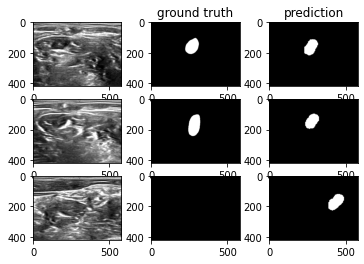

In [0]:
import matplotlib.pyplot as plt

def standardise(array, mean, std, to_float=False):
    """Standardise the given array.

    The output array will have mean zero and standard deviation 1.

    :param array: an array to be standardised
    :param to_float: boolean parameter of whether to convert the input array to float
    :return: standardised version of the input array
    """
    if to_float:
        array = np.array(array, dtype=np.float32)

    array -= mean
    array /= std
    return array

print("Load Data...")
trainImages, trainMasks = load_train_data()

X_test, y_test = trainImages[0:100,:], trainMasks[0:100,:] # 100 first images with their masks

print('Loading and pre-processing test data...')
imgs_test = X_test
imgs_test = preprocess(imgs_test)
mean, std = load_pickle('res/meanstd.dump') # 99.88485 56.971313
imgs_test = standardise(imgs_test, mean, std, to_float=True)


model = Nest_Net(lr = 2e-4) # best model
img_rows, img_cols = 96,96
print('Loading best saved weights...')
load_pretrained_model(model, pretrained_path='res/nestnet_aug.hdf5') 

print('Predicting masks on test data...')
imgs_mask_test = model.predict(imgs_test, verbose=1)

idx = [7, 8, 15]

plt.figure(300)

# First prediction
plt.subplot(331)
plt.imshow(X_test[idx[0],:,:,0],cmap='gray') # image

plt.subplot(332)
plt.imshow(y_test[idx[0],:,:,0],cmap='gray') # ground truth mask
plt.title('ground truth')

plt.subplot(333)
plt.imshow(prep(imgs_mask_test[idx[0], :, :,0]),cmap='gray') # predicted mask
plt.title('prediction')


# Second prediction
plt.subplot(334)
plt.imshow(X_test[idx[1],:,:,0],cmap='gray')

plt.subplot(335)
plt.imshow(y_test[idx[1],:,:,0],cmap='gray')

plt.subplot(336)
plt.imshow(prep(imgs_mask_test[idx[1], :, :, 0]),cmap='gray')


# Third prediction
plt.subplot(337)
plt.imshow(X_test[idx[2],:,:,0],cmap='gray')
plt.subplot(338)
plt.imshow(y_test[idx[2],:,:,0],cmap='gray')

plt.subplot(339)
plt.imshow(prep(imgs_mask_test[idx[2], :, :, 0]),cmap='gray')


for i, id in enumerate(idx):
  dice = np_dice_coef(prep(y_test[id,:,:,0]), prep(imgs_mask_test[id, :, :, 0]), smooth=1)
  print("The dice coefficient for the line {} is {}".format(i, round(dice,2)))